# Training using Backpropagation

Let's use the ```autograd``` feature to enable training using backpropagation. A general flow of training follows:
- Repeat for as many epochs:
    - Repeat until one epoch:
        - Extract a batch from the training set,
        - Execute a **forward pass** to obtain predictions on the batch,
        - Compute the **loss**,
        - Compute the **gradient** of the loss function w.r.t the weights using ```autograd```,
        - **Update the weights** using the gradients propagated using backpropagation,


In [37]:
import os
import torch
import torchvision
import numpy as np
import seaborn as sns

from scipy import io
from torch import nn
from torch import optim 
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from matplotlib import pyplot as plt

torch.set_printoptions(linewidth=120)

Let's set the following:
- Training dataset - MNIST with batch size $100$
- Convolutional Neural Network

In [4]:
class MNIST(Dataset):
    def __init__(self, transform=None):
        data = io.loadmat('./../datasets/MNIST/mnist_training_data.mat')
        labels = io.loadmat('./../datasets/MNIST/mnist_training_label.mat')
        
        self.num_samples = len(data['training_data'])
        self.samples = data['training_data'].reshape(self.num_samples, 28, 28)[:,None].astype(np.float32)
        self.targets = labels['training_label'][:,0].astype(np.int64)
        self.transform = transform
    
    def __getitem__(self, index):
        if self.transform:
            return self.transform(self.samples[index]), self.targets[index]
        else:
            return self.samples[index], self.targets[index]
    
    def __len__(self):
        return self.num_samples

In [5]:
train_set = MNIST()
print(len(train_set))
print(train_set.targets)
# print(train_data.targets.bincount())
# Make bincount feature, comment on the balance of the dataset

50000
[0 0 0 ... 9 9 9]


In [6]:
batch_size = 100
train_loader = DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True
)

Let's use the convolutional neural network and instantiate an object network.

In [7]:
class ConvNetwork(nn.Module):
    
    def __init__(self):
        super(ConvNetwork, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        
        self.dense1 = nn.Linear(in_features=12*4*4, out_features=120)
        self.dense2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)
        
    def forward(self, x):
        # (1) hidden conv layer
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        
        # (2) hidden conv layer
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        
        # (3) hidden linear layer
        x = x.reshape(-1, 12*4*4)
        x = self.dense1(x)
        x = F.relu(x)
        
        # (4) hidden linear layer
        x = self.dense2(x)
        x = F.relu(x)
        
        # (5) output layer
        x = self.out(x)
        # x = F.softmax(x, dim=1) # This will be implemented within the loss function
        
        return x

In [8]:
network = ConvNetwork()
network

ConvNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (dense1): Linear(in_features=192, out_features=120, bias=True)
  (dense2): Linear(in_features=120, out_features=60, bias=True)
  (out): Linear(in_features=60, out_features=10, bias=True)
)

Let's compute the cross-entropy loss on one batch, and also, see how many predictions it gets right.

In [9]:
def get_num_correct(predictions, labels):
    return F.softmax(predictions, dim=1).argmax(dim=1).eq(labels).sum().item()

In [10]:
batch = next(iter(train_loader))
images, labels = batch

In [11]:
predictions = network(images)
loss = F.cross_entropy(predictions, labels)
loss.item()

2.3089396953582764

In [12]:
get_num_correct(predictions, labels)

5

Let's use the ```backward()``` module attached to the loss function to compute the gradients using backpropagation. The gradients can be computed using the computational graph that is carried over to the loss function by the ```predictions``` tensor computed during the forward pass.

In [13]:
print(network.conv1.weight.grad)

None


In [14]:
loss.backward()

In [15]:
print(network.conv1.weight.grad)
print(network.conv1.weight.grad.shape)

tensor([[[[-1.2025e-03, -4.2539e-04,  8.6052e-04,  1.9625e-03,  2.4795e-03],
          [-6.2868e-04, -2.1840e-06,  1.4146e-03,  1.4703e-03,  1.6656e-03],
          [-2.3702e-04,  5.8718e-04,  1.0351e-03,  1.2767e-03,  1.1774e-03],
          [ 1.4713e-04,  5.6665e-04,  1.1945e-03,  1.3665e-03,  7.6529e-04],
          [ 2.9348e-04, -7.9188e-05,  3.0587e-04,  9.8698e-05, -1.6978e-04]]],


        [[[-1.3499e-03, -9.2008e-04,  3.7518e-04,  8.8864e-04,  1.3828e-04],
          [-1.1854e-03, -2.8092e-04,  4.7713e-05, -2.8618e-04, -9.5897e-04],
          [-1.0705e-03, -5.5679e-04, -6.3794e-04, -1.6312e-03, -1.8088e-03],
          [-1.2722e-03, -1.0289e-03, -1.4042e-03, -2.2241e-03, -2.0690e-03],
          [-1.0911e-03, -1.6828e-03, -1.6657e-03, -1.7943e-03, -1.9395e-03]]],


        [[[-8.5157e-04, -1.6332e-03, -8.4922e-04, -4.0067e-04, -3.5049e-04],
          [-1.2006e-03, -1.1869e-03, -8.5564e-04, -8.1732e-04, -7.3436e-04],
          [-1.3193e-04, -1.4425e-04, -4.9229e-05, -3.2223e-04, -2.87

Notice that the gradient of the loss w.r.t the weights of ```conv1``` have the same shape as the weights of the layer. Using these gradients, we use an optimiser to update all parameters of the network.

In [16]:
optimiser = optim.Adam(network.parameters(), lr=0.01)
optimiser.step()

In [17]:
predictions = network(images)
loss = F.cross_entropy(predictions, labels)
loss.item()

2.265723705291748

In [18]:
get_num_correct(predictions, labels)

12

We expect the loss on the same batch to decrese and the number of correct predictions to increase.

We can now put all this together to train with all the images to make an epoch, and then to run multiple epochs.

In [19]:
model = ConvNetwork()
optimiser = optim.Adam(model.parameters(), lr=0.01)

num_epochs = 5
for epoch in range(num_epochs):
    training_loss = 0
    training_accuracy = 0
    for batch in train_loader:
        # Load a batch
        images, labels = batch
        
        # Execute a forward pass
        predictions = model(images)
        
        # Compute the loss
        loss = F.cross_entropy(predictions, labels)
        
        # Compute gradients
        optimiser.zero_grad()
        loss.backward()
        
        # Update the weights
        optimiser.step()
        
        training_loss += loss.item()
        accuracy += get_num_correct(predictions, labels) / len(train_set)
        
    print("epoch: %d \t training accuracy: %f \t loss: %f" %(epoch, accuracy, training_loss))

epoch: 0 	 accuracy: 0.916500 	 loss: 131.098976
epoch: 1 	 accuracy: 0.971000 	 loss: 48.721128
epoch: 2 	 accuracy: 0.976180 	 loss: 40.642286
epoch: 3 	 accuracy: 0.978580 	 loss: 37.545998
epoch: 4 	 accuracy: 0.979600 	 loss: 35.114310


We can now save the model using ```torch.save()```, and use the trained model later.

In [21]:
os.makedirs('./../models', exist_ok=True)
path = './../models/'
torch.save(model, path + 'model_CNN_dataset_MNIST_method_Adam_epochs_' + str(num_epochs) + '.pth')

We can then load the model using ```torch.load()```.

In [23]:
model = torch.load(path + 'model_CNN_dataset_MNIST_method_Adam_epochs_' + str(num_epochs) + '.pth')
model.eval()

ConvNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (dense1): Linear(in_features=192, out_features=120, bias=True)
  (dense2): Linear(in_features=120, out_features=60, bias=True)
  (out): Linear(in_features=60, out_features=10, bias=True)
)

In [24]:
print(model.conv1.weight)

Parameter containing:
tensor([[[[-0.2589, -0.1816, -0.2574, -0.2567,  0.0420],
          [-0.0781,  0.3618,  0.3701, -0.4409, -0.7600],
          [-0.1132,  0.1207,  0.4947,  0.1722, -0.4734],
          [-0.3470, -0.1445,  0.4332,  0.3510,  0.4995],
          [-0.6661, -0.0501,  0.0483,  0.0542,  0.1181]]],


        [[[-0.7712, -0.2901,  0.2578,  0.1321,  0.2475],
          [-0.3980,  0.6015,  0.5483, -0.2451,  0.0054],
          [ 0.3374,  0.4657, -0.2507, -0.2887, -0.1204],
          [ 0.0080, -0.0721, -0.1369, -0.1670, -0.3166],
          [ 0.1099,  0.3159, -0.0152, -0.0824, -0.1423]]],


        [[[ 0.0552,  0.1269,  0.0289,  0.1342, -0.1974],
          [ 0.3401,  0.3437,  0.0160,  0.3601,  0.1320],
          [-0.0458,  0.0541, -0.1236,  0.0649, -0.0247],
          [ 0.1987, -0.1245, -0.2811, -0.3728, -0.3026],
          [-0.3764, -0.8028, -0.3071, -0.0088,  0.0758]]],


        [[[-0.1953, -0.2918,  0.2427, -0.0169, -0.1973],
          [-0.0774,  0.1304,  0.3077,  0.2867, -0.0603

We can use the model now to test on testing data. We import and transform the test data.

In [27]:
test_data = io.loadmat('./../datasets/MNIST/mnist_test_data.mat')
test_labels = io.loadmat('./../datasets/MNIST/mnist_test_label.mat')

num_test_samples = len(test_data['test_data'])
test_samples = test_data['test_data'].reshape(num_test_samples, 28, 28)[:, None].astype(np.float32)
test_labels = test_labels['test_label'][:,0].astype(np.int64)

test_samples = torch.tensor(test_samples)
test_labels = torch.tensor(test_labels)

In [29]:
num_classes = 10
with torch.no_grad():
    predictions = model(test_samples)
    predictions = torch.argmax(predictions, dim=1)
    confusion_mtx = np.zeros((num_classes, num_classes))
    for i in range(num_classes):
        for j in range(num_classes):
            confusion_mtx[i,j] = sum((test_labels==i) & (predictions==j))

In [31]:
testing_accuracy = sum(np.diag(confusion_mtx))/sum(sum(confusion_mtx)) * 100
testing_accuracy

98.32

We now write a function to plot the confusion matrix.

In [67]:
def plot_confusion_matrix(data, ax=None, xaxis_label=r'PREDICTED CLASS',
    yaxis_label=r'TRUE CLASS', map_min=0.0, map_max=1.0, title_text=None,
    show=True, save=False):
    ''' Plots confusion matrix '''
    if ax is None:
        fig = plt.figure(figsize=(8,8))
        ax = plt.gca()

    ax = sns.heatmap(data, vmin=map_min, vmax=map_max, linewidths=0.5,
        annot=True, fmt=".0f", cmap="GnBu_r")
    # ax.invert_yaxis()
    plt.xlabel(xaxis_label)
    plt.ylabel(yaxis_label)
    plt.title(title_text)

    if save:
        plt.savefig(save + '.pdf', format='pdf')

    if show:
        plt.show()

    return

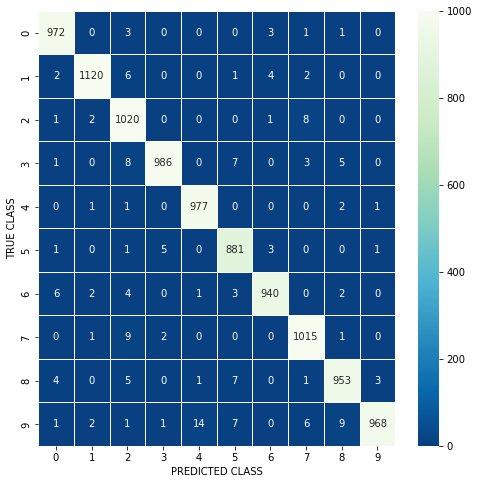

In [68]:
plot_confusion_matrix(confusion_mtx, map_max=1000)